In [1]:
#다음 코드는 google colab에서 작성되었다.
#colab에서 한글을 printing하기 위한 작업이다.
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
from google.colab import drive
drive.mount('/content/gdrive')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (6,914 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 160837 files and d

In [1]:
#분석에 필요한 여러 라이브러리들을 먼저 import해준다.
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import urllib.request
import datetime
import json
import glob
import sys
import os

from fbprophet import Prophet

import warnings
warnings.filterwarnings(action='ignore')

%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.grid'] = False
plt.rc('font', family='NanumBarunGothic') 

pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)
pd.set_option('display.width', 100)

pd.options.display.float_format = '{:.2f}'.format

In [4]:
#네이버 데이터랩 오픈 APi를 이용하기 위한 클래스 생성과정이다.
class NaverDataLabOpenAPI():
    """
    네이버 데이터랩 오픈 API 컨트롤러 클래스
    """

    def __init__(self, client_id, client_secret):
        """
        인증키 설정 및 검색어 그룹 초기화
        """
        self.client_id = client_id
        self.client_secret = client_secret
        self.keywordGroups = []
        self.url = "https://openapi.naver.com/v1/datalab/search"

    def add_keyword_groups(self, group_dict):
        """
        검색어 그룹 추가
        """

        keyword_gorup = {
            'groupName': group_dict['groupName'],
            'keywords': group_dict['keywords']
        }
        
        self.keywordGroups.append(keyword_gorup)
        print(f">>> Num of keywordGroups: {len(self.keywordGroups)}")

    def get_data(self, startDate, endDate, timeUnit, device, ages, gender):
        """
        요청 결과 반환
        """

        # Request body
        body = json.dumps({
            "startDate": startDate,
            "endDate": endDate,
            "timeUnit": timeUnit,
            "keywordGroups": self.keywordGroups,
            "device": device,
            "ages": ages,
            "gender": gender
        }, ensure_ascii=False)
        
        # Results
        request = urllib.request.Request(self.url)
        request.add_header("X-Naver-Client-Id",self.client_id)
        request.add_header("X-Naver-Client-Secret",self.client_secret)
        request.add_header("Content-Type","application/json")
        response = urllib.request.urlopen(request, data=body.encode("utf-8"))
        rescode = response.getcode()
        if(rescode==200):
            # Json Result
            result = json.loads(response.read())
            
            df = pd.DataFrame(result['results'][0]['data'])[['period']]
            for i in range(len(self.keywordGroups)):
                tmp = pd.DataFrame(result['results'][i]['data'])
                tmp = tmp.rename(columns={'ratio': result['results'][i]['title']})
                df = pd.merge(df, tmp, how='left', on=['period'])
            self.df = df.rename(columns={'period': '날짜'})
            self.df['날짜'] = pd.to_datetime(self.df['날짜'])
            
        else:
            print("Error Code:" + rescode)
            
        return self.df

    def plot_daily_trend(self):
        """
        일 별 검색어 트렌드 그래프 출력
        """
        colList = self.df.columns[1:]
        n_col = len(colList)

        fig = plt.figure(figsize=(12,6))
        plt.title('일 별 검색어 트렌드', size=20, weight='bold')
        for i in range(n_col):
            sns.lineplot(x=self.df['날짜'], y=self.df[colList[i]], label=colList[i])
        plt.legend(loc='upper right')
        
        return fig

    def plot_monthly_trend(self):
        """
        월 별 검색어 트렌드 그래프 출력
        """
        df = self.df.copy()
        df_0 = df.groupby(by=[df['날짜'].dt.year, df['날짜'].dt.month]).mean().droplevel(0).reset_index().rename(columns={'날짜': '월'})
        df_1 = df.groupby(by=[df['날짜'].dt.year, df['날짜'].dt.month]).mean().droplevel(1).reset_index().rename(columns={'날짜': '년도'})

        df = pd.merge(df_1[['년도']], df_0, how='left', left_index=True, right_index=True)
        df['날짜'] = pd.to_datetime(df[['년도','월']].assign(일=1).rename(columns={"년도": "year", "월":'month','일':'day'}))
        
        colList = df.columns.drop(['날짜','년도','월'])
        n_col = len(colList)
                
        fig = plt.figure(figsize=(12,6))
        plt.title('월 별 검색어 트렌드', size=20, weight='bold')
        for i in range(n_col):
            sns.lineplot(x=df['날짜'], y=df[colList[i]], label=colList[i])
        plt.legend(loc='upper right')
        
        return fig

    def plot_pred_trend(self, days):
        """
        검색어 그룹 별 시계열 트렌드 예측 그래프 출력
        days: 예측일수
        """
        colList = self.df.columns[1:]
        n_col = len(colList)
        
        fig_list = []
        for i in range(n_col):
            
            globals()[f"df_{str(i)}"] = self.df[['날짜', f'{colList[i]}']]
            globals()[f"df_{str(i)}"] = globals()[f"df_{str(i)}"].rename(columns={'날짜': 'ds', f'{colList[i]}': 'y'})

            m = Prophet()
            m.fit(globals()[f"df_{str(i)}"])

            future = m.make_future_dataframe(periods=days)
            forecast = m.predict(future)
            forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
            
            globals()[f"fig_{str(i)}"] = m.plot(forecast, figsize=(12,6))
            plt.title(colList[i], size=20, weight='bold')
            
            fig_list.append(globals()[f"fig_{str(i)}"])
            
        return fig_list

In [5]:
#'캠핑', '차박' 두 개의 키워드를 이용해 검색하기 위해 keyword_group을 다음과 같이 잡았다.
keyword_group_set = {
    'keyword_group_1': {'groupName': "캠핑", 'keywords': ["캠핑용품","캠핑장소","캠핑지"]},
    'keyword_group_2': {'groupName': "차박", 'keywords': ['차박용품',"차박소품","차박여행"]},
}

In [6]:
client_id = "zHeGk6GV3rLuzBYhKhCS"
client_secret = "8z9APom3rx"

# 요청 파라미터 설정
# 우리 그룹에서 필요한 기간과 연령대를 parameter값으로 전달해준다. 
startDate = "2017-01-01"
endDate = "2021-05-31"
timeUnit = 'date'
device = ''
ages = ['3','4','5','6'] #age 3~6에 해당되는 게 MZ세대이다.
gender = ''

# 데이터 프레임 정의
naver = NaverDataLabOpenAPI(client_id=client_id, client_secret=client_secret)

naver.add_keyword_groups(keyword_group_set['keyword_group_1'])
naver.add_keyword_groups(keyword_group_set['keyword_group_2'])

df = naver.get_data(startDate, endDate, timeUnit, device, ages, gender)

>>> Num of keywordGroups: 1
>>> Num of keywordGroups: 2


In [7]:
#이를 dataframe으로 뽑아서 확인한다.
df.head()

,날짜,캠핑,차박
0,2017-01-01,3.30,0.50
1,2017-01-02,4.02,0.26
2,2017-01-03,3.46,0.29
3,2017-01-04,3.34,0.19
4,2017-01-05,3.05,0.39


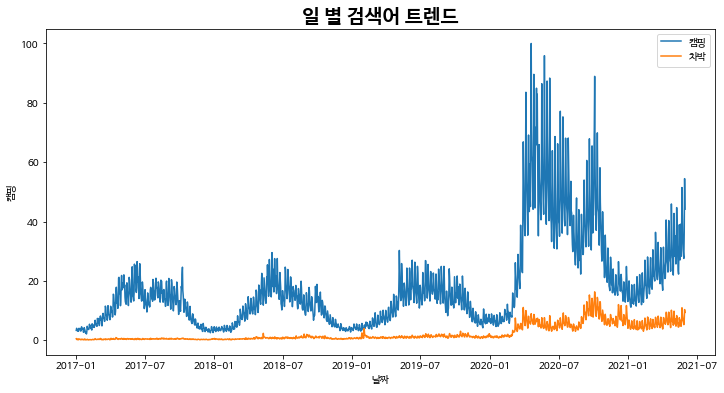

In [10]:
#일별 기준으로 '캠핑', '차박'의 검색량 변화량을 보여주는 그래프다.
fig_1 = naver.plot_daily_trend()

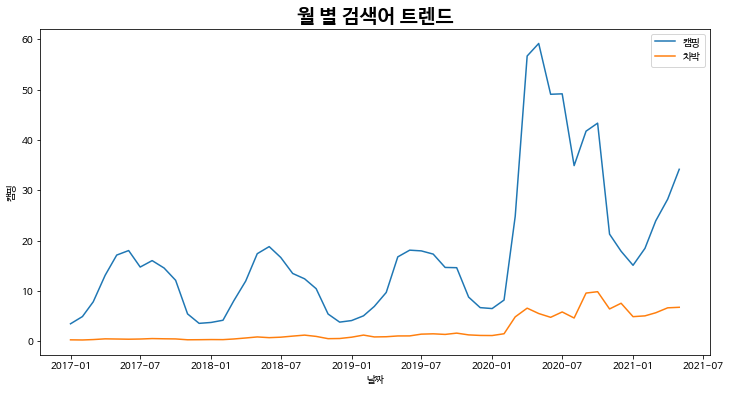

In [11]:
#월별 기준으로 '캠핑', '차박'의 검색량 변화량을 보여주는 그래프다.
fig_2 = naver.plot_monthly_trend()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


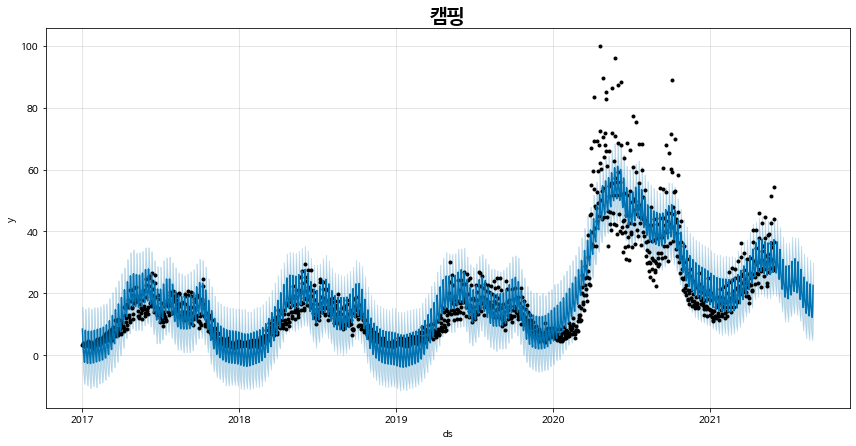

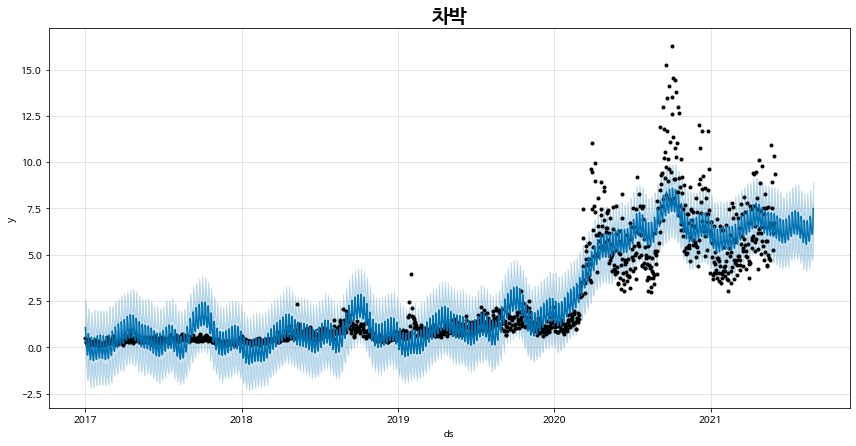

In [12]:
#앞으로의 트렌드가 어떻게 변할 지 파악할 수 있는 그래프이다.
fig_3 = naver.plot_pred_trend(days = 90)